# Get a Biomass function using a GSM

## Kugler2023
**Model Publication:**  
Kugler, A., Stensjö, K. Optimal energy and redox metabolism in the cyanobacterium Synechocystis sp. PCC 6803. npj Syst Biol Appl 9, 47 (2023). https://doi.org/10.1038/s41540-023-00307-3

**Available at:**  
https://github.com/amitkugler/CBA

## Knoop2015
**Model Publication:**  
Knoop H and Steuer R (2015) A computational analysis of stoichiometric constraints and trade-offs in cyanobacterial biofuel production. Front. Bioeng. Biotechnol. 3:47. doi: 10.3389/fbioe.2015.00047

**Available at:**  
https://www.frontiersin.org/articles/file/downloadfile/136766_supplementary-materials_datasheets_1_zip/octet-stream/Data%20Sheet%201.ZIP/1/136766?isPublishedV2=False

In [239]:
import pandas as pd
import numpy as np
from pathlib import Path
import sys

from cobra.io import load_json_model, read_sbml_model
from cobra.flux_analysis.loopless import add_loopless, loopless_solution
from cobra.flux_analysis import pfba

from cobra import Model, Reaction, Metabolite
from cobra.manipulation.validate import check_mass_balance

from modelbase.ode import Simulator
from modelbase.ode import ratefunctions as rf

sys.path.append("../Code")
import functions as fnc
import calculate_parameters_restruct as prm
import functions_light_absorption as lip

# Import model functions
from get_current_model import get_model

In [79]:
select_model = "Kugler2023"
# select_model = "Knoop2015"
# select_model = "Knoop2013"

In [80]:
def add_import(model, metabolite_name, reaction_stoichiometry, bounds=(-1000,1000)):
    # Define the reaction
    reac = Reaction(f'{metabolite_name}_import')
    reac.name = f'{metabolite_name} import'
    reac.bounds = bounds

    # Add the correct stoichiometry and add to the model
    reac.add_metabolites({model.metabolites.get_by_id(k): v for k,v in reaction_stoichiometry.items()})
    model.add_reactions([reac])
    
    return model

In [81]:
def get_stoichiometric_fluxes(model, solution, compound):
    # Get the reactions where the compound is involved and their stoichiometry
    react = solution.fluxes[[x.id for x in model.metabolites.get_by_id(compound).reactions]]
    stoich = pd.Series({x:model.reactions.get_by_id(x).metabolites[model.metabolites.get_by_id(compound)] for x in react.index})
    
    # Return the scaled flux according to the stoichiometry
    return react * stoich

In [82]:
# Load the model
if select_model == "Kugler2023":
    model = load_json_model('../GSM_models/Kugler2023/GSM/JSON/iJN678_AK.json')

    # Set phototrophic growth and modify the model as described in the Analysis by Kugler
    #set model objective to autotrophic growth
    model.objective = 'BIOMASS_Ec_SynAuto'
    #set photoautotropic growth by constraining glucose exchange reatcion
    model.reactions.EX_glc__D_e.bounds = (0, 1000)
    #set photoautotropic growth by constraining HCO3 exchange reatcion.
    model.reactions.EX_co2_e.bounds = (0, 1000)
    model.reactions.EX_hco3_e.bounds = (-3.7, 1000)
    #set photon flux to lab scale conditions.
    model.reactions.EX_photon_e.bounds = (-45, -45)
    #blocking transhydrogenase PntAB
    model.reactions.NADTRHD.bounds = (0, 0)

    # Make the model loopless (makes model infeasible)
    # add_loopless(model)

elif select_model == "Knoop2015":
    model = read_sbml_model("../GSM_models/Knoop2015/Knoop2015_Supplement_revised/Metabolic_Network_supplementary_File1.xml")

    # Constraints used for the FBA simulation
    # Photon input
    model.reactions.PR0001.bounds = (0,15.57)

elif select_model == "Knoop2013":
    model = read_sbml_model("../GSM_models/Knoop2013/pcbi.1003081.s002.xml")

In [42]:
with model:
    sol_loopless = loopless_solution(model)

In [60]:
solutions = {}
#############
# Get the default flux
solutions["default"] = model.optimize("maximize")
solutions["default_pfba"] = pfba(model)

In [70]:
model.metabolites.C00031_ext_b

Metabolite identifier,C00031_ext_b
Name,D-Glucose_ext_b
Memory address,0x7fd37d743310
Formula,C6H12O6
Compartment,ext
In 2 reaction(s),"EX_C00031_ext_b, R676"


In [62]:
model.summary(solutions["default"])

Metabolite,Reaction,Flux,C-Number,C-Flux
C00007_ext_b,EX_C00007_ext_b,490.1,0,0.00%
C00009_ext_b,EX_C00009_ext_b,30.43,0,0.00%
C00031_ext_b,EX_C00031_ext_b,321.3,6,73.61%
C00034_ext_b,EX_C00034_ext_b,0.1285,0,0.00%
C00038_ext_b,EX_C00038_ext_b,0.1285,0,0.00%
C00059_ext_b,EX_C00059_ext_b,7.285,0,0.00%
C00062_ext_b,EX_C00062_ext_b,63.65,6,14.58%
C00064_ext_b,EX_C00064_ext_b,57.06,5,10.90%
C00070_ext_b,EX_C00070_ext_b,0.1285,0,0.00%
C00076_ext_b,EX_C00076_ext_b,0.1925,0,0.00%


In [54]:
model.metabolites.B3_cyt

Metabolite identifier,B3_cyt
Name,RNA component of biomass_cyt
Memory address,0x7fd37dce2ad0
Formula,R
Compartment,cyt
In 2 reaction(s),"R84, R90"


In [49]:
check_mass_balance(model)

{<Reaction R82 at 0x7fd36929b590>: {'C': -44.957,
  'H': -70.7206,
  'N': -12.106,
  'O': -13.169299999999996,
  'S': -0.267},
 <Reaction R83 at 0x7fd3681b2090>: {'C': -31.7501,
  'H': -39.88170000000001,
  'N': -12.1576,
  'O': -19.518,
  'P': -3.2525000000000004,
  'R': 1.0},
 <Reaction R84 at 0x7fd369113d10>: {'C': -29.609900000000003,
  'H': -36.628,
  'N': -11.632100000000001,
  'O': -21.904900000000005,
  'P': -3.1190999999999987,
  'R': 1.0},
 <Reaction R85 at 0x7fd3683b8bd0>: {'C': -44.897999999999996,
  'H': -80.3888,
  'N': -3.8484,
  'O': -17.104,
  'P': -0.4276,
  'R': 1.0},
 <Reaction R86 at 0x7fd367da95d0>: {'C': -12.29,
  'H': -18.35,
  'O': -11.835,
  'P': -0.1,
  'R': -1.0,
  'S': -0.255},
 <Reaction R87 at 0x7fd3680f8590>: {'C': -11.519999999999998,
  'H': -25.158999999999995,
  'O': -2.3880000000000003,
  'P': -0.28800000000000003,
  'Co': -0.008,
  'N': -4.373,
  'S': -0.044,
  'Fe': -0.024,
  'R': 1.0},
 <Reaction R88 at 0x7fd368044710>: {'Ca': -0.454,
  'Mo': -0.3

In [ ]:

with model:
    ##############
    # With imports
    # Disable light reactions
    model.reactions.EX_photon_e.bounds = (0, 0)

    # Disable NDH-1 as we want to measure ATP import
    # model.reactions.get_by_id("NDH1_1u").bounds = (0, 0)
    # model.reactions.get_by_id('NDH1_2u').bounds = (0, 0)
    # model.reactions.get_by_id('NDH1_3u').bounds = (0, 0)
    # model.reactions.get_by_id('NDH1_4pp').bounds = (0, 0)
    

    # # Disable Terminal oxidases
    model.reactions.get_by_id('CYO1b_syn').bounds = (0, 0) # COX
    model.reactions.get_by_id("CYTBDu").bounds = (0, 0) # Cyd
    model.reactions.get_by_id("CYTBDpp_1").bounds = (0, 0) # Cyd
    model.reactions.get_by_id('Flv2_4').bounds = (0, 0) # Flv2/4
    model.reactions.get_by_id('ARTO').bounds = (0, 0) # ARTO

    # # Disable H2 production
    # model.reactions.get_by_id("H2ASE_syn").bounds = (0, 0)

    # # Disable Cyt b6f
    # model.reactions.get_by_id('CBFC2').bounds = (0, 0)

    # # Disable the Mehler reaction
    model.reactions.get_by_id("MEHLER").bounds = (0, 0)

    # # model.reactions.get_by_id("ATPS4rpp_1").bounds = (0,0)
    # model.reactions.get_by_id("ATPSu").bounds = (0,0)

    # Instead, add Exchange reactions for ATP, NADPH and 3PGA
    pseudo_reactions = {
        "3PGA":  ({"3pg_c":1}, (-1, 1)),
        "ATP":   ({"atp_c":1, "adp_c":-1}, (0, 1000)),
        "NADPH": ({"nadph_c":1, "h_c":1, "nadp_c":-1}, (0, 1000)),
        "H+": ({"h_c":1}, (-1000, 1000)),
    }
    for name, (stoich, bounds) in pseudo_reactions.items():
        model = add_import(model, name, stoich, bounds)

    # Set a new objective function
    model.objective = {
        model.reactions.get_by_id('BIOMASS_Ec_SynAuto'):0.9,
        model.reactions.get_by_id('ATP_import'):0.1,
    
    }

    # Disable other Carbon import reactions
    # HCO3 import
    # model.reactions.EX_hco3_e.lower_bound = 0

    solutions["imports"] = model.optimize("maximize")
    solutions["imports_pfba"] = pfba(model)

    print(model.summary(solutions["imports"]))

# Print a summary of the models
for nam, sol in solutions.items():
    print(f"""
model: {nam}
biomass: {sol.fluxes.get("BIOMASS_Ec_SynAuto")}
ATP: {sol.fluxes.get("ATP_import")}
NADPH: {sol.fluxes.get("NADPH_import")}
3PGA: {sol.fluxes.get("3PGA_import")}
""")

In [311]:
comp = "atp_c"
flux = get_stoichiometric_fluxes(model, solutions["imports_pfba"], comp)
flux.sort_values()

PGK                   -6.292459
PRUK                  -3.709389
BIOMASS_Ec_SynAuto    -0.894048
NO3abcpp              -0.150675
ACCOAC                -0.049223
                        ...    
CYSTRS                -0.000000
PPK2                   0.000004
URIDK2r                0.000441
PYK                    0.012969
ATPS4rpp_1            10.278579
Length: 157, dtype: float64

In [292]:
model.reactions.get_by_id(flux.idxmax())

Reaction identifier,ICDHyr
Name,Isocitrate dehydrogenase (NADP)
Memory address,0x73e5a673bd60
Stoichiometry,icit_c + nadp_c --> akg_c + co2_c + nadph_c Isocitrate + Nicotinamide adenine dinucleotide phosphate --> 2-Oxoglutarate + CO2 CO2 + Nicotinamide adenine dinucleotide phosphate - reduced
GPR,icd
Lower bound,0.0
Upper bound,1000.0


In [293]:
model.reactions.get_by_id(flux.idxmin())

Reaction identifier,NDH1_4pp
Name,Active co2 transporter facilitator (periplasm)
Memory address,0x73e5a6043ac0
Stoichiometry,co2_p + h2o_c + 3.0 h_c + nadph_c + pq_p --> 3.0 h_p + hco3_c + nadp_c + pqh2_p CO2 CO2 + H2O H2O + 3.0 H+ + Nicotinamide adenine dinucleotide phosphate - reduced + Plastoquinone --> 3.0 H+ + Bicarbonate + Nicotinamide adenine dinucleotide phosphate + Plastoquinol
GPR,ndhA and ndhB and ndhC and ndhE and ndhG and ndhH and ndhI and ndhJ and (ndhK or sll8031) and...
Lower bound,0.0
Upper bound,1000.0


In [222]:
solutions["imports"]

,fluxes,reduced_costs
EX_ac_e,0.780510,1.135629e-16
34DHOXPEGOX,0.000000,-0.000000e+00
EX_photon_e,0.000000,0.000000e+00
34HPPOR,0.000007,0.000000e+00
EX_ca2_e,-0.000062,0.000000e+00
...,...,...
Flv2_4,0.000000,8.296147e-03
NGAM,0.000000,-1.935768e-02
3PGA_import,1.000000,2.765382e-02
ATP_import,-0.990456,-0.000000e+00


In [223]:
model.reactions.get_by_id(x).metabolites[model.metabolites.get_by_id("atp_c")]

-1.0

In [51]:
dir(model.metabolites.get_by_id("atp_c"))

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_annotation',
 '_bound',
 '_id',
 '_model',
 '_reaction',
 '_repr_html_',
 '_set_id_with_model',
 'annotation',
 'charge',
 'compartment',
 'constraint',
 'copy',
 'elements',
 'formula',
 'formula_weight',
 'id',
 'model',
 'name',
 'notes',
 'reactions',
 'remove_from_model',
 'shadow_price',
 'summary',
 'y']

In [48]:
model.reac

Reaction identifier,GLU5K
Name,Glutamate 5-kinase
Memory address,0x73e5a685e020
Stoichiometry,atp_c + glu__L_c --> adp_c + glu5p_c ATP C10H12N5O13P3 + L-Glutamate --> ADP C10H12N5O10P2 + L-Glutamate 5-phosphate
GPR,proB
Lower bound,0.0
Upper bound,1000.0


In [37]:
sol.fluxes[[x.id for x in model.metabolites.get_by_id("atp_c").reactions]]

GLU5K                   0.016914
PRAIS                   0.023215
NGAM                    0.000000
ACGK                    0.019483
HEX7                    0.000000
                          ...   
PRASCSi                 0.023215
HSK                     0.038820
TYRTRS                  0.000000
BIOMASS_Ec_SynHetero    0.000000
NADS2                   0.000163
Name: fluxes, Length: 158, dtype: float64

In [38]:
dir(model.reactions)

['34DHOXPEGOX',
 '34HPPOR',
 '3HAD100',
 '3HAD120',
 '3HAD121',
 '3HAD140',
 '3HAD141',
 '3HAD160',
 '3HAD161',
 '3HAD180',
 '3HAD181',
 '3HAD40',
 '3HAD60',
 '3HAD80',
 '3OAR100',
 '3OAR120',
 '3OAR121',
 '3OAR140',
 '3OAR141',
 '3OAR160',
 '3OAR161',
 '3OAR180',
 '3OAR181',
 '3OAR40',
 '3OAR60',
 '3OAR80',
 '3OAS100',
 '3OAS120',
 '3OAS121',
 '3OAS140',
 '3OAS141',
 '3OAS160',
 '3OAS161',
 '3OAS180',
 '3OAS181',
 '3OAS60',
 '3OAS80',
 'AACOAR_syn',
 'ABTA',
 'ABUTD',
 'ACACT1r',
 'ACBIPGT',
 'ACCOAC',
 'ACGK',
 'ACGS',
 'ACHBS',
 'ACKr',
 'ACLS',
 'ACOATA',
 'ACONT',
 'ACOTA',
 'ACP1_FMN',
 'ACS',
 'ACt2rpp',
 'ACtex',
 'ADCL',
 'ADCPS1',
 'ADCPS2',
 'ADCS',
 'ADCYRS',
 'ADK1',
 'ADMDC',
 'ADNCYC',
 'ADOCBLS',
 'ADPRDP',
 'ADPT',
 'ADPT2',
 'ADSK',
 'ADSL1r',
 'ADSL2r',
 'ADSS',
 'AGMT',
 'AGPAT160',
 'AGPAT161',
 'AGPAT180',
 'AGPAT181',
 'AGPAT181_9',
 'AGPAT182_9_12',
 'AGPAT183_6_9_12',
 'AGPAT183_9_12_15',
 'AGPAT184_6_9_12_15',
 'AGPR',
 'AGTi',
 'AHCi',
 'AHMMPS',
 'AHSERL2',


In [30]:
solutions["default_pfba"].fluxes['BIOMASS_Ec_SynAuto']

0.08239889629798884

In [27]:
solutions["default_pfba"]

,fluxes,reduced_costs
EX_ac_e,0.000000,461.333333
34DHOXPEGOX,0.000000,2.000000
EX_photon_e,-45.000000,17.000000
34HPPOR,0.000043,-2.000000
EX_ca2_e,-0.000372,2.000000
...,...,...
GLYCLc,0.008998,-2.000000
NDH2_1p,0.000000,48.000000
ARTO,0.000000,-2.000000
Flv2_4,0.000000,28.000000


In [5]:
sol.fluxes.get("ATP_import")
sol.fluxes.get("NADPH_import")
sol.fluxes.get("3PGA_import")

-0.8895669489038693

## Add biomass reaction to model

In [211]:
# Get the default model
_m = get_model(get_y0=False, verbose=False, check_consistency=False)

stoich_3PGA = pd.Series({
    "CO2": -3,
    "ATP": -8,
    "NADPH": -5,
    "3PGA": 1,
})

In [223]:
# Biomass stoichiometry as given in Knoop2015
# This reaction has to complete once for a full division
biomass_Knoop2015 = pd.Series({ # [mmol gDW(Biomass)^-1]
    "NADPH": -90, 
    "ATP": -191,
    "CO2": -41.5,
    
    "3PGA": 0, # Added for compliance with the model
})

# Transform to usage of 3PGA
biomass_Knoop2015 = biomass_Knoop2015 - (stoich_3PGA / stoich_3PGA["CO2"] * biomass_Knoop2015["CO2"])
biomass_Knoop2015 = biomass_Knoop2015.drop("CO2")
biomass_Knoop2015["Ho"] = biomass_Knoop2015["NADPH"] / _m.get_parameter("bHo")

# Calculate the conversion from gDW to mol(Chl)
mChl_DW = 10 # [mg gDW^-1] (Zavrel2019)
MChl = 893.509 # [g mol^-1]

nChl_DW = ( # [mol gDW^-1]
    mChl_DW 
    * 1e-3 # [g mg^-1]
    / MChl # [g mol^-1]
)

# Scale the biomass stoichiometry to mol Chl
biomass_Knoop2015 = biomass_Knoop2015 / nChl_DW # [mmol mol(Chl)^-1]


# Get the growth rate of the 633nm (red)-light grown cells
growth_rate= pd.read_csv("../Code/data/Strainparameters_Zavrel2021.csv", header=0,skiprows=1, index_col=0).loc["Specific growth rate","633"] # [h^-1]
growth_rate = growth_rate / 3600 # [s^-1]

In [250]:
# Get the default model
m, y0 = get_model(verbose=False, check_consistency=False)

# Set the initial 3PGA concentration to zero
y0["3PGA"] = 0

# Add a biomass reaction as Mass action
biomass_stoich = biomass_Knoop2015.to_dict()

# Add parameter(s) and reaction to model
m.add_parameter("k_biomass", growth_rate * 10)
m.add_reaction_from_args(
    "vBiomass",
    function = rf.mass_action_variable,
    stoichiometry = biomass_stoich,
    args = ["k_biomass"] + list(biomass_stoich.keys()),
)

# Make container to save the mus
mus = {}

for intens in np.linspace(25,1000, 20):
    # Simulate
    s = Simulator(m)

    s.update_parameter("pfd", lip.light_gaussianLED(633, intens))

    s.initialise(y0)
    t,y = s.simulate(1000)

    mus[intens] = s.get_fluxes_df().loc[:,"vBiomass"].iloc[-1]

Text(0.5, 0, 'Light intensity [µmol m$^{-2}$ s$^{-1}$]')

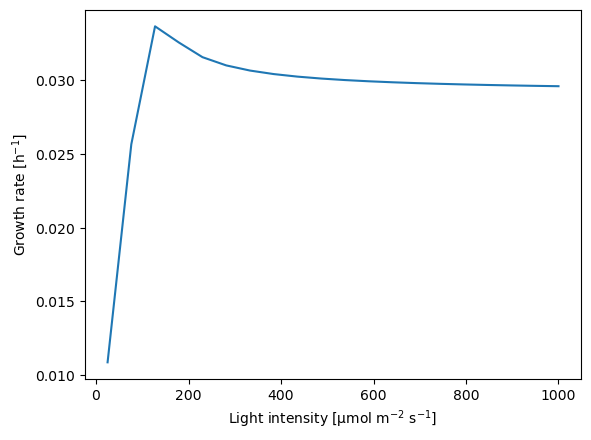

In [249]:
ax = (pd.Series(mus) * 3600 ).plot()
ax.set_ylabel("Growth rate [h$^{-1}$]")
ax.set_xlabel("Light intensity [µmol m$^{-2}$ s$^{-1}$]")

(<Figure size 1000x700 with 1 Axes>,
 <Axes: xlabel='Remember to label your axes', ylabel='Remember to label your axes'>)

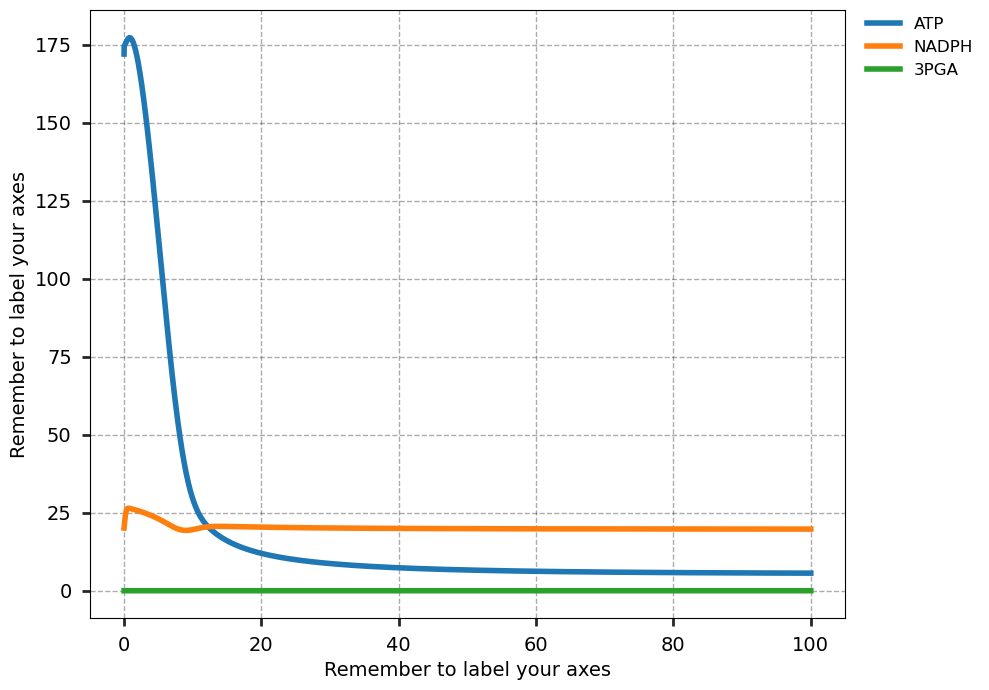

In [236]:
s.plot_selection(["ATP", "NADPH", "3PGA"])

(<Figure size 1000x700 with 1 Axes>,
 <Axes: xlabel='Remember to label your axes', ylabel='Remember to label your axes'>)

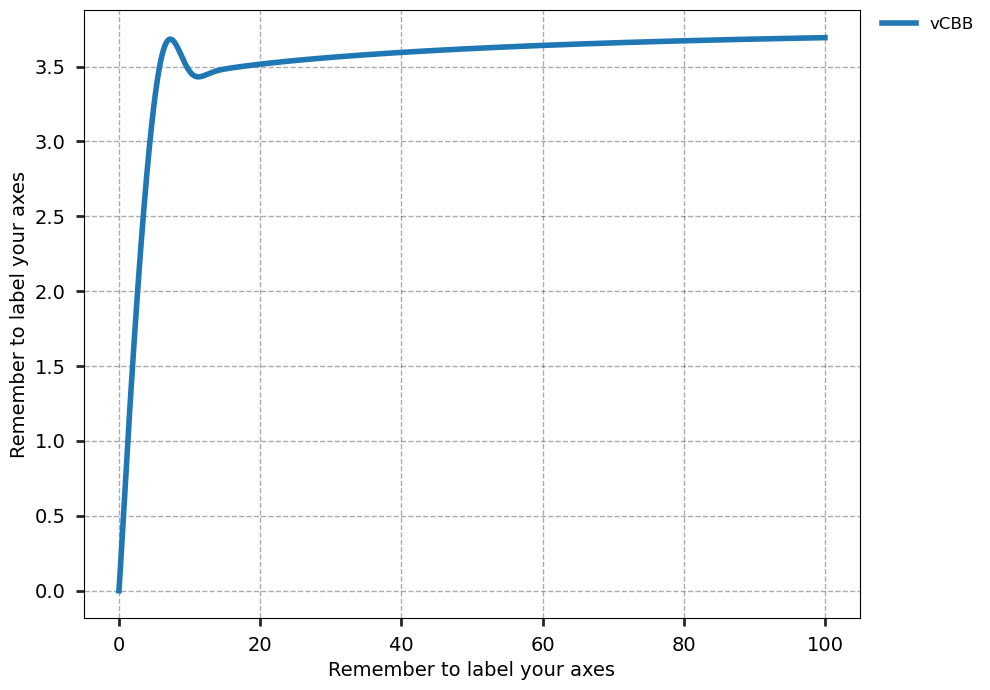

In [237]:
s.plot_flux_selection("vCBB")

In [230]:
s.get_fluxes_df().loc[:,"vBiomass"].iloc[-1]

5.052127365330565e-06

In [231]:
growth_rate

9.444444444444446e-05